In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

![title](logo-utn.png)

## *Fundamentos de la Robótica Móvil.*
### Trabajo Practico N° 4: : Sistemas en tiempo discreto

---

### Autor 
* Sanchez Marengo, Nahuel

### Objetivo

Estudiar el comportamiento de lazo cerrado de un sistema multirrotor de un grado de libertad tipo balancı́n utilizando simulación. Se propone crear un modelo en tiempo discreto basado en ecuaciones en diferencias cuya evolución temporal se realizará utilizando funciones de bucle en Python.


---

In [2]:
import matplotlib.pyplot as plt

def plot_q_u(q, u, ts):
    fig = plt.figure(figsize=(10,10))
    plt.subplot(3, 1, 1), plt.plot(ts, q[0, :], ), plt.grid(True)
    plt.ylabel(r'$q_1 (\theta)$ [rad]'), #plt.xlabel('t [s]')
    plt.subplot(3, 1, 2), plt.plot(ts, q[1, :]), plt.grid(True)
    plt.ylabel(r'$q_2 (\omega)$ [rad/s]'), #plt.xlabel('t [s]')
    plt.subplot(3, 1, 3), plt.plot(ts, u[0, :]), plt.grid(True)
    plt.ylabel('$u$'), plt.xlabel('t [s]')
    plt.show()
    
linestyle = ('solid', 'dotted', 'dashed')

## Respuesta del modelo discreto

---

A continuación, se realiza la simulación del modelo discreto para condiciones iniciales nulas y distintos valores de acción de control. 


In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import control

from plot_q_u import plot_q_u

# Parámetros de simulación.
J = 100e-3      # Momento de inercia
T = 5           # Tiempo de simulación
dt = 0.001      # Intervalo de muestreo
N = int(T/dt)   # Índice máximo de estados discretos

for ones_or_zeros in [0, 1]:
    # Vector de tiempos discretos
    ts = np.linspace(0, T-dt, N)

    # Vector de estado inicial.
    # q1 = theta; q2 = theta_punto
    q0 = np.array( (0, 0) )

    # Vector de estado e inicialización.
    q = np.zeros( (2, N) )
    q[:, 0] = q0

    # Vector de acciones de control.
    u = np.ones( (1, N) )*ones_or_zeros

    # Matrices del sistema de estado discretizado.
    A = np.array([ [1, dt], [0, 1] ])
    B = np.array([ [0], [dt/J] ])

    # Bucle para el cálculo de los estados.
    for i in range(1, N):
        q[:, i] = A.dot( q[:, i-1] ) + B.dot( u[:, i-1] )


    fig = plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 1), plt.plot(ts, q[0, :], label='q = {}'.format(q0)), plt.grid(True), plt.legend(loc=1)
    plt.ylabel(r'$q_1 (\theta)$ [rad]')
    plt.subplot(3, 1, 2), plt.plot(ts, q[1, :]), plt.grid(True)
    plt.ylabel(r'$q_2 (\omega)$ [rad/s]')
    plt.subplot(3, 1, 3), plt.plot(ts, u[0, :]), plt.grid(True)
    plt.ylabel('$u$'), plt.xlabel('t [s]')
    fig.suptitle('Figura {}. Modelado discreto con u=[{}]'.format(1+ones_or_zeros, ones_or_zeros), y=0.92, fontsize=14)
    plt.show()

Como se ve en las gráficas de las Figura 1, cuando la acción de control es nula el sistema no cambia de estado, manteniéndose en el punto de equilibrio inicial. En cambio, al hacer 1 la acción de control, el sistema evoluciona con velocidad constante. 

## Análisis de los puntos de equilibrio

A continuación, se varían las condiciones iniciales del sistema para verificar la existencia otros puntos de equilibrio distinto de q = [0, 0]. En la Figura 3 se grafica la respuesta del sistema para distintas posiciones angulares y velocidad inicial nula, mientras que en la Figura 4 se grafica para distintas velocidades iniciales y posición angular nula.

In [4]:
Q0 = np.array( (((0, 0),  (5, 0), (10, 0)), ((0, 2),  (0, 5), (0, 10))) ) # Condiciones iniciales a graficar
u = np.zeros( (1, N) )
ign = 0

for Q in Q0:
    fig, ax = plt.subplots(2, 1);
    fig.set_size_inches(10, 6)
    for j, q0 in enumerate(Q):
        q = np.zeros( (2, N) )
        q[:, 0] = q0

        for i in range(1, N):
            q[:, i] = A.dot( q[:, i-1] ) + B.dot( u[:, i-1] )

        ax[0].plot(ts, q[0, :], ls=linestyle[j], label='q0 = '+str(q0))
        ax[1].plot(ts, q[1, :], ls=linestyle[j], label='q0 = '+str(q0))

    fig.suptitle('Figura {}. Respuesta del sistema ante distintas posiciones angulares iniciales'.format(3 + ign), y=0.92, fontsize=14)
    ign = ign + 1
    ax[0].set_ylabel(r'$q_1 (\theta)$ [rad]', fontsize=14), ax[0].legend(loc=1), ax[0].grid()
    ax[1].set_ylabel(r'$q_2 (\omega)$ [rad/s]', fontsize=14), ax[1].legend(loc=1), ax[1].grid()
    ax[0].legend(loc=1)
    ax[1].legend(loc=1)
    plt.xlabel('t [s]', fontsize=14)
    plt.show()

Analizando las respuestas de las Figuras 1 y 2, se comprueba que para acción de control nula, el equilibrio se logra únicamente si $\omega_0=0$ independientemente del valor de $\theta_0$. Por lo tanto, nos encontramos con infinitos puntos de equilibrio.

## Compensador proporcional

A continuación, se obtiene un modelo a lazo cerrado añadiendo un compensador proporcional, para lo cual se modifica el vector de control `u`, tomando una muestra de la posición angular de salida que es comparada con una valor de referencia `ref`.

Text(0, 0.5, '$u$')

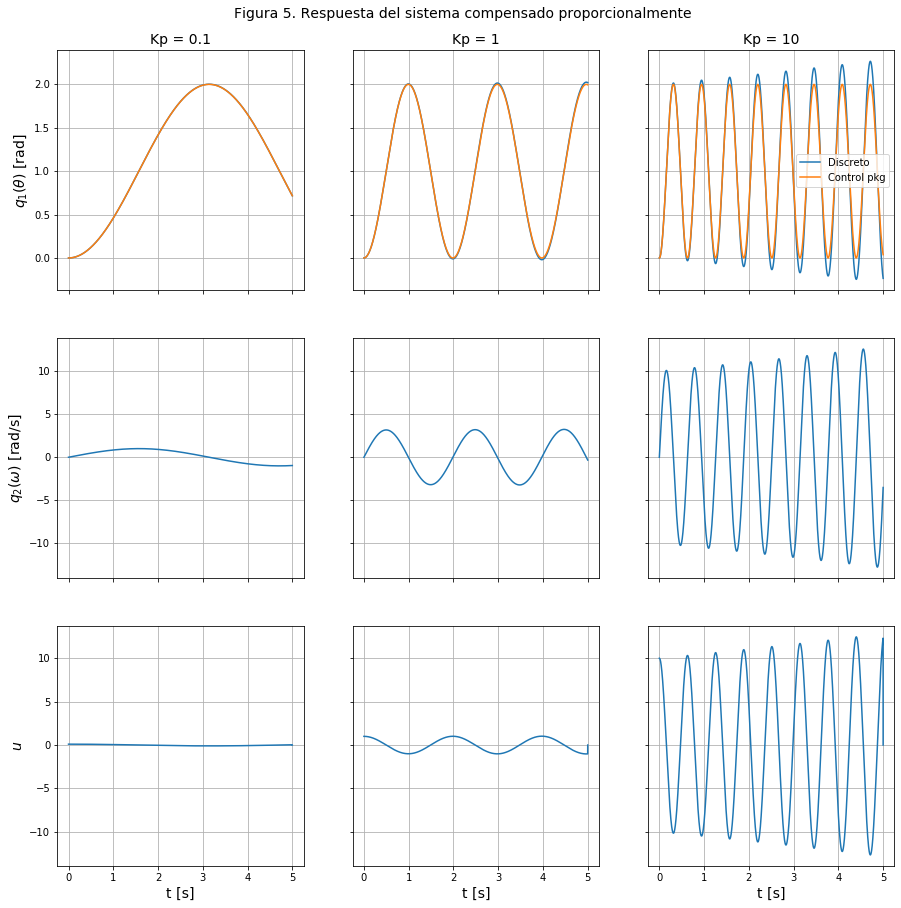

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [5]:
ref = 1 # Referencia angular [rad]
KP = [0.1, 1, 10]
q0 = np.array( (0, 0) )

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row');
fig.suptitle('Figura 5. Respuesta del sistema compensado proporcionalmente', y=0.92, fontsize=14)
fig.set_size_inches(15, 15)



for j, Kp in enumerate(KP):
    q = np.zeros( (2, N) )
    q[:, 0] = q0
    u = np.zeros( (1, N) )

    # Modelado discreto
    for i in range(1, N):
        u[:, i-1] = Kp * (ref - q[0, i-1])
        q[:, i] = A.dot( q[:, i-1] ) + B.dot( u[:, i-1] )

    # Modelado a través del paquete control
    Gol = control.tf([1], [J,0,0])
    GclK = control.feedback(Kp*Gol)
    t, yout = control.step_response(GclK, T=ts)


    fig = plt.figure(figsize=(10,10))
    ax[0, j].plot(ts, q[0, :], label='Discreto'), ax[0, j].grid()
    ax[0, j].plot(t, yout, label='Control pkg')
    ax[1, j].plot(ts, q[1, :]), ax[1, j].grid()
    ax[2, j].plot(ts, u[0, :]), ax[2, j].grid()
    ax[0, j].set_title('Kp = ' + str(Kp), fontsize=14)
    ax[2, j].set_xlabel('t [s]', fontsize=14)
    
ax[0,0].set_ylabel(r'$q_1 (\theta)$ [rad]', fontsize=14)
ax[0,2].legend()
ax[1,0].set_ylabel(r'$q_2 (\omega)$ [rad/s]', fontsize=14)
ax[2,0].set_ylabel('$u$', fontsize=14)

Al comparar las gráficas previamente obtenidas con las obtenidas en el TP2 , se comprueba que el modelo discretizado efectivamente modela el comportamiendo del sistema continuo. Al analizar la evolución de la señal de control u, se ve que el valor que alcance es directamente proporcional al valor de Kp. Esto último puede ser un problema debido a la saturación de los actuadores reales.

Se observa también un error acumulado en la amplitud de la señal angular. En la Figura 6, se grafica la respuesta para Kp=10 y distintos valores de período de muestreo `dt` con lo que se comprueba que este error se debe al proceso de discretización. 

In [6]:
ref = 1 # Referencia angular [rad]
Kp = 20
DT = [0.002, 0.001, 0.0005]
q0 = np.array( (0, 0) )

fig = plt.figure(figsize=(15,5))
fig.suptitle('Figura 6. Error del modelo discreto para distintos períodos de muestreo', y=0.92, fontsize=14)


# Modelado a través del paquete control
Gol = control.tf([1], [J,0,0])
GclK = control.feedback(Kp*Gol)
t, yout = control.step_response(GclK, T=ts)
plt.plot(t, yout, label='Control pkg')

for dt in DT:
    N = int(T/dt)
    ts = np.linspace(0, T-dt, N)
    q = np.zeros( (2, N) )
    q[:, 0] = q0
    u = np.zeros( (1, N) )
    A = np.array([ [1, dt], [0, 1] ])
    B = np.array([ [0], [dt/J] ])
    
    # Modelado discreto
    for i in range(1, N):
        u[:, i-1] = Kp * (ref - q[0, i-1])
        q[:, i] = A.dot( q[:, i-1] ) + B.dot( u[:, i-1] )

    plt.plot(ts, q[0, :], label='dt = '+str(dt))
    
plt.ylabel(r'$q_1 (\theta)$ [rad]', fontsize=14)
plt.ylabel('$u$', fontsize=14)
plt.legend(loc=1)
plt.grid()

# Restaura valores originales
dt = 0.001      # Intervalo de muestreo
N = int(T/dt)   # Índice máximo de estados discretos
# Vector de tiempos discretos
ts = np.linspace(0, T-dt, N)
# Matrices del sistema de estado discretizado.
A = np.array([ [1, dt], [0, 1] ])
B = np.array([ [0], [dt/J] ])

## Compensador derivativo

A continuación se implementa un compensador derivarivo en serie con el lazo directo, es decir derivando la señal de error, tal como se realizó en TP2. Se modela de forma discreta el sistema mostrado en la Figura X:

![title](ft2.png)

Para $G_{ol}(s)=\frac{1}{s^2J}$:

$$
G_{cl}(s)=\frac{K_p T_d s+K_p}{Js^2+K_p T_d s +K_p}
$$

En la Figura 7 se corrobora que la respuesta obtenida es idéntica a la obtenida a través del paquete `control`. Sin embargo, se ve que para lograr este comportamiento, es necesario que la acción de control u tome valores excesivamente grandes al inicio, con una aceleración impráctica en $t \approx 0$. 

In [7]:
ref = 1 # Referencia angular en rad
Kp = 1
Td = 0.1

q0 = np.array( (0, 0) )
q = np.zeros( (2, N) )
q[:, 0] = q0

u = np.zeros( (1, N) )
error = np.zeros( (1, N) )

# Modelado discreto
for i in range(1, N):
    q[:, i] = A.dot( q[:, i-1] ) + B.dot( u[:, i-1] )
    error[0, i] = ref - q[0, i]
    u[:, i] = Kp * (error[0, i] + Td * (error[0, i]-error[0, i-1])/dt)

# Modelado a través del paquete control
KD = control.tf([Kp*Td, Kp], [1])
GclKD = control.feedback(KD*Gol)
t, yout = control.step_response(GclKD, T=ts)    

fig = plt.figure(figsize=(10,10))
plt.subplot(4, 1, 1), plt.plot(ts, q[0, :], label='Discreto'), plt.grid(True)
plt.plot(t, yout, label='Control pkg', ls='dashed', linewidth=3)
plt.ylabel(r'$q_1 (\theta)$ [rad]'), plt.legend()
plt.subplot(4, 1, 2), plt.plot(ts[1:], q[1, 1:]), plt.grid(True)
plt.ylabel(r'$q_2 (\omega)$ [rad/s]'), #plt.xlabel('t [s]')
plt.subplot(4, 1, 3), plt.plot(ts, u[0, 0:]), plt.grid(True)
plt.ylabel('$u$'), plt.xlabel('t [s]')
plt.subplot(4, 1, 4), plt.plot(ts, u[0, 0:]), plt.grid(True), plt.ylim(-2, 2)
plt.ylabel('$u$ (zoom)'), plt.xlabel('t [s]')
fig.suptitle('Figura 7. Respuesta del sistema con compensador proporcional y derivativo', y=0.92, fontsize=14)

plt.show()

Finalmente se implementa lo propuesto por el enunciado de este TP, derivando directamente la señal de salida $\theta_o$. A partir del diagrama en bloques la función de transferencia queda:

$$
G_{cl}(s)=\frac{K_p}{Js^2+K_p T_d s +K_p}
$$

![title](ft3.png)

En la Figura 8 se grafica la respuesta del sistema compensado para distintos valores de Kp y Td.

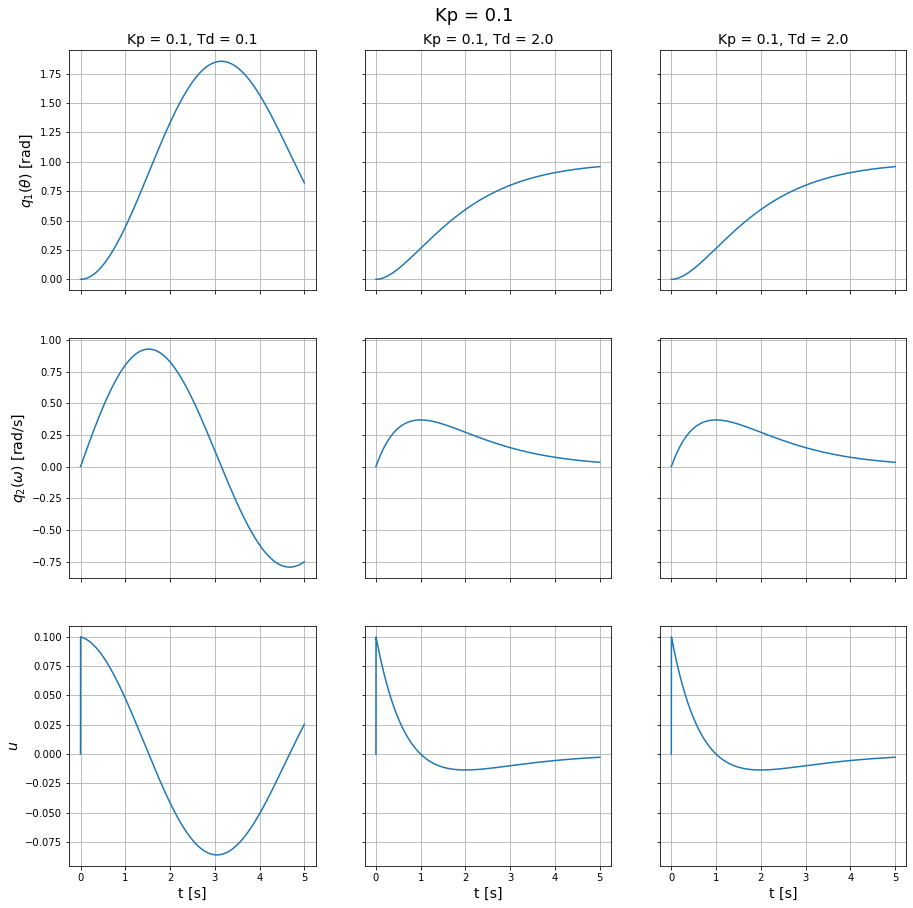

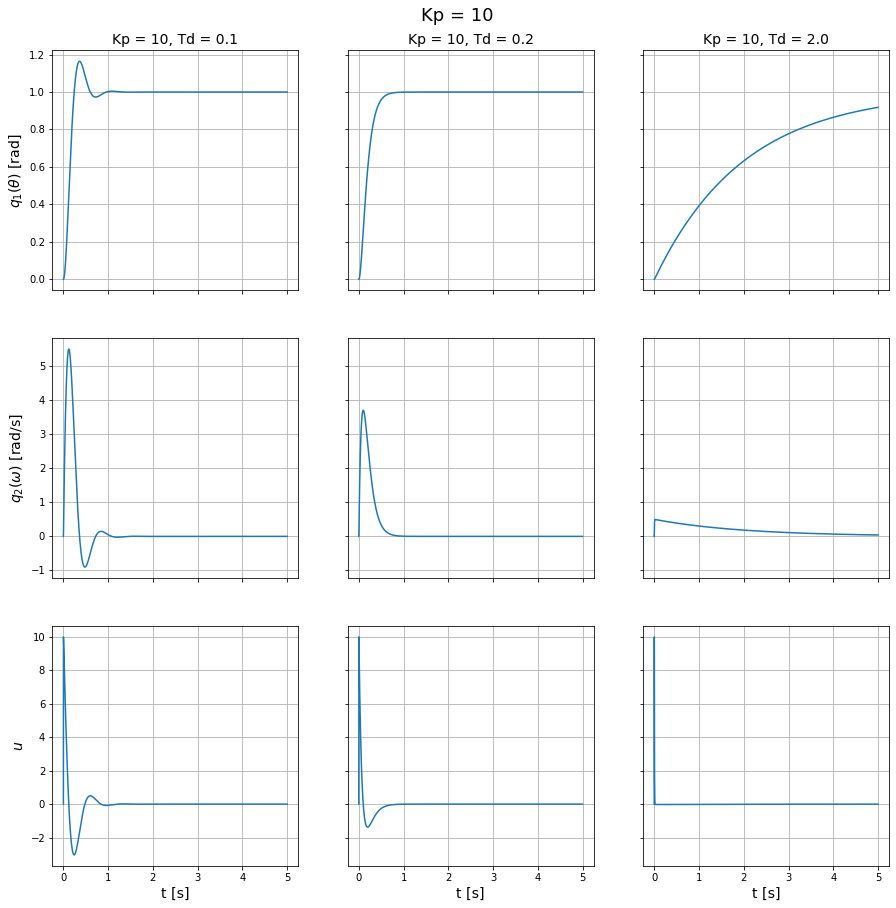

In [8]:
ref = 1 # Referencia angular [rad]
KP = [0.1, 1, 10] #valores de Kp a plotear
q0 = np.array( (0, 0) )

for Kp in KP:
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row');
    fig.suptitle('Kp = '+str(Kp), fontsize=18, y=0.92)
    fig.set_size_inches(15, 15)
    tdcrit = math.sqrt(4*J/Kp)
    TD = np.array([0.1, tdcrit, 2]) # valores de Td a plotear para cada valor de Kp
    TD = np.sort(TD)
    for j, Td in enumerate(TD):
        q = np.zeros( (2, N) )
        q[:, 0] = q0
        u = np.zeros( (1, N) )

        # Modelado discreto
        for i in range(1, N):
            q[:, i] = A.dot( q[:, i-1] ) + B.dot( u[:, i-1] )
            error[0, i] = ref - q[0, i]
            u[:, i] = Kp * (error[0, i] + Td * (q[0, i-1]-q[0, i])/dt)
        

        #fig = plt.figure(figsize=(10,10))
        ax[0, j].plot(ts, q[0, :]), ax[0, j].grid()
        ax[1, j].plot(ts, q[1, :]), ax[1, j].grid()
        ax[2, j].plot(ts, u[0, :]), ax[2, j].grid()
        ax[0, j].set_title('Kp = ' + str(Kp)+', Td = ' + str(Td), fontsize=14)
        ax[2, j].set_xlabel('t [s]', fontsize=14)
    
    ax[0,0].set_ylabel(r'$q_1 (\theta)$ [rad]', fontsize=14)
    ax[1,0].set_ylabel(r'$q_2 (\omega)$ [rad/s]', fontsize=14)
    ax[2,0].set_ylabel('$u$', fontsize=14)
    




Se ve que cuando mayor es la velocidad de respuesta del sistema, mayor es la magnitud que toma la señal de contorl u.

## Ruido

A continuación, se añade ruido a la medición de la posición angular que es proporcional a la misma.

In [ ]:
ref = 1 # Referencia angular en rad
Kp = 1
Tdcrit = math.sqrt(4 * J / Kp)
Td = Tdcrit
FN = [0.02, 0.05]

fign = 0

for fn in FN: 
    q0 = np.array( (0, 0) )
    q = np.zeros( (2, N) )
    qn = np.zeros( (2, N) )
    qe = np.zeros( (2, N) )
    q[:, 0] = q0
    u = np.zeros( (1, N) )
    error = np.zeros( (1, N) )
    error[0, 0] = q0[0]

    for i in range(1, N):
        q[:, i] = A.dot( q[:, i-1] ) + B.dot( u[:, i-1] )
        q[0, i] = q[0, i] + fn*(np.random.rand() - 0.5) * q[0, i]
        u[:, i] = Kp * (ref - q[0, i] + Td * (q[0, i-1]-q[0, i])/dt)
        
    fig = plt.figure(figsize=(10,10))
    plt.subplot(3, 1, 1), plt.plot(ts, q[0, :], ), plt.grid(True)
    plt.ylabel(r'$q_1 (\theta)$ [rad]'), #plt.xlabel('t [s]')
    plt.subplot(3, 1, 2), plt.plot(ts, q[1, :]), plt.grid(True)
    plt.ylabel(r'$q_2 (\omega)$ [rad/s]'), #plt.xlabel('t [s]')
    plt.subplot(3, 1, 3), plt.plot(ts, u[0, :]), plt.grid(True)
    plt.ylabel('$u$'), plt.xlabel('t [s]')
    fig.suptitle('Figura {}. Respuesta del sistema con adición de ruido del {}%'.format(8+fign, FN[fign]*100), y=0.92, fontsize=14)
    fign = fign + 1
    plt.show()

Como se ve en la Figura 8 y 9 el compensador derivativo produce grandes variaciones en la acción de control u, resultando es un mayor ruido de salida.

## Conclusiones

---

En primer lugar se comprobó que tal como se de esperar, el modelo discretizado responde de forma similar al modelo en tiempo continuo previamente analizado. También se comprobó que para el sistema a lazo abierto existen infinitos puntos de equilibrio siempre y cuando la velocidad inicial sea nula.

Tras implementar el compensador proporcional, se verificó que la discretización del sistema produce un error acumulativo en el tiempo que puede ser reducido al disminuir el período de muestreo.

Se implementó un compensador derivativo en el lazo de realimentación tomando una muestra de la posición angular de salida, y se graficó su dinámica para distintos valores de Kp y Kd.

Finalmente, se muestran los efectos de la adición de ruido en la medición de la posción angular y el problema que implica utilizar compensadores derivativos. Se observa cómo se degrada la señal de salida.
